# Chapter 3 - Developing Templates

Generating SoftMax distributions from normals could get quite tedious – for any sufficiently complicated shape, the number of normals to be used could be excessive. Let's add a layer of abstraction onto all our work.

##Polygon Construction

We can put everything together from all we've talked about (shifting the distribution and generating weights from normals) to a more tangible process: generating a softmax distribution from a [polytope](http://en.wikipedia.org/wiki/Polytope). Let's motivate this with an example first.

Imagine you worked at the Pentagon as an HRI researcher. One day, while pondering the nature of language, you happened to look out your window and spot an intruder. If you called a human security officer, you might say something like, "I see an intruder in front of the Heliport facade." We can use our SoftMax classifier to translate this same sentence for a security bot to understand.

First, we'd need to divide the space in a similar way we did for the Pac-Man problem:

<img src="https://raw.githubusercontent.com/COHRINT/cops_and_robots/master/notebooks/softmax/img/pentagon.png" alt="Pentagon space division" width="500px">

As opposed to our Pac-Man problem, we can't assign weights by inspection. Instead, we'll use our weights-from-normals tactic to generate our weights for each class, and our shifted bias tactic to place those weights appropriately.

### Step 1: Define Polytope
We can use a geometry library like [Shapely](http://toblerity.org/shapely/shapely.html) to define custom polytopes (in this case, a pentagon). For a quick way to get ideal pentagon vertex coordinates, you can either calculate them by hand or use [some online tools](http://www.mathsisfun.com/geometry/pentagon.html). 

Let's try a pentagon with the following coordinates (starting at the corner between the South Parking Entrance and the Heliport Facade):

$$
\begin{align}
P_1 &= (P_{1x}, P_{1y}) = (-1.90,-0.93) \\
P_2 &= (-1.40,1.45) \\
P_3 &= (1.03,1.71) \\
P_4 &= (2.02,-0.51) \\
P_5 &= (0.21,-2.15) \\
\end{align}
$$


### Step 2: Get Normals and Offsets
We want to get six classes, so we'd like to specify $\frac{6(6-1)}{2} = 15$ normal vectors in order to use our transformation matrix $A$. But, we only have six unknowns, so we can reduce the size of our $A$ matrix. That is, we can use:

$$
\mathbf{N} = \begin{bmatrix}
\mathbf{n}_{0,1}^T \\
\mathbf{n}_{0,2}^T \\
\mathbf{n}_{0,3}^T \\
\mathbf{n}_{0,4}^T \\
\mathbf{n}_{0,5}^T \\
\mathbf{n}_{1,2}^T \\
\end{bmatrix} 
= \begin{bmatrix}
-1 & 1 & 0 & 0 & 0 & 0 \\
-1 & 0 & 1 & 0 & 0 & 0 \\
-1 & 0 & 0 & 1 & 0 & 0 \\
-1 & 0 & 0 & 0 & 1 & 0 \\
-1 & 0 & 0 & 0 & 0 & 1 \\
0 & -1 & 1 & 0 & 0 & 0 \\
\end{bmatrix}
\begin{bmatrix}
\mathbf{w}_{0}^T \\
\mathbf{w}_{1}^T \\
\mathbf{w}_{2}^T \\
\mathbf{w}_{3}^T \\
\mathbf{w}_{4}^T \\
\mathbf{w}_{5}^T \\
\end{bmatrix} 
= \mathbf{A}\mathbf{W}
$$

Where $\mathbf{n}_{0,1}$ is the boundary between the interior and the South Parking Entrance, and so on. 

Except, we can be smarter about this. We only care about the *relative* weights, so why not define one class and solve for the weights of all other classes? Since we have one interior class with weights $w_0$, simply define $w_0 = \begin{bmatrix}0 & 0 \end{bmatrix}^T$ and $b_0 = 0$, leaving us with the following five equations and five unkowns:

$$
\mathbf{N} = \begin{bmatrix}
\mathbf{n}_{0,1}^T \\
\mathbf{n}_{0,2}^T \\
\mathbf{n}_{0,3}^T \\
\mathbf{n}_{0,4}^T \\
\mathbf{n}_{0,5}^T \\
\end{bmatrix} 
= \begin{bmatrix}
1 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 1 \\
\end{bmatrix}
\begin{bmatrix}
\mathbf{w}_{1}^T \\
\mathbf{w}_{2}^T \\
\mathbf{w}_{3}^T \\
\mathbf{w}_{4}^T \\
\mathbf{w}_{5}^T \\
\end{bmatrix} 
= \mathbf{A}\mathbf{W}
$$

Does it make sense that the weights we'd use correspond directly to the class boundaries of each class with some zero-weighted interior class? Yes: think of a class boundary as defined by its normal vector. Those normal vectors point exactly in the direction of greatest probability of a given class.

Thus, we have:

$$
\mathbf{n}_{0,i} = \mathbf{w}_{i} \; \forall i \in N
$$

We have the normals, but solving for the class biases will require digging deeper. We need the equation for a normal fixed to the surface of the polytope (not simply its magnitude and direction!).

In $\mathbb{R}^2$, we know that a line is uniquely defined by two points passing through it – a face's bounding vertices, for instance. This can help us find the normal vectors and offsets, giving us the weights and biases.

Recall the specification of our hyperplanes in $\mathbb{R}^2$:

\begin{align}
0 &= (\mathbf{w}_i - \mathbf{w}_j)^T\mathbf{x} + (b_i - b_j) \\
  &= (w_{i,x} - w_{j,x})x + (w_{i,y} - w_{j,y})y + (b_i - b_j) \\
  &= w_{i,x}x + w_{i,y}y + b_i
\end{align}

Where the last line assumes $j$ is the interior class with weights and a bias of 0.

Since we have two points on this line segment (and any third point from a linear combination of the first two), we can use their $x$ and $y$ values to calculate our weights:

\begin{equation}\label{eq:nullspace}
\begin{bmatrix}
x_1 & y_1 & 1 \\
x_2 & y_2 & 1 \\
x_3 & y_3 & 1 \\
\end{bmatrix}
\begin{bmatrix}
w_{i,x}\\
w_{i,y}\\
b_i
\end{bmatrix}
=\begin{bmatrix}
0\\
0\\
0
\end{bmatrix}
\end{equation}

The non-trivial solution to $\ref{eq:nullspace}$ can be found through various decomposition techniques. We use [Singular Value Decomposition](http://en.wikipedia.org/wiki/Singular_value_decomposition).

In short, given any polygon, we can use its vertices to find the equations of the normals representing the class boundaries between the interior class and an exterior class for each face. Let's try this out and see if it works well.

Note that this part, as well as several future ones, require long swaths of code 
to be fully explained. Rather than include the code in this document, you can always find it 
on [our Github](https://github.com/COHRINT/cops_and_robots/blob/master/src/cops_and_robots/robo_tools/fusion/softmax.py).

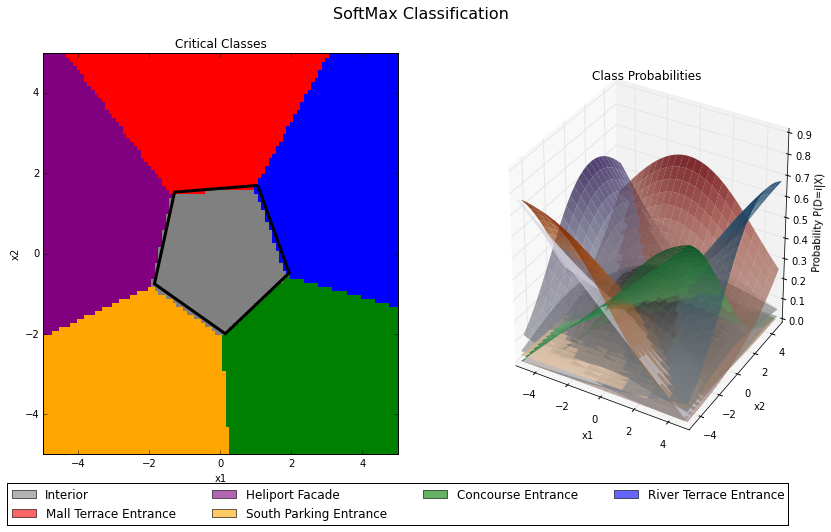

In [1]:
import numpy as np
%matplotlib inline

from cops_and_robots.robo_tools.fusion.softmax import SoftMax, make_regular_2D_poly
poly = make_regular_2D_poly(5, max_r=2, theta=np.pi/3.1)
labels = ['Interior',
          'Mall Terrace Entrance',
          'Heliport Facade',
          'South Parking Entrance', 
          'Concourse Entrance',
          'River Terrace Entrance', 
         ]
sm = SoftMax(poly=poly, class_labels=labels, resolution=0.1)
sm.plot(plot_poly=True, plot_normals=False)
    

**NOTE: 3D Plotting currently borked**

Well, that looks like the class boundaries are lining up just fine, but what about the probability distributions themselves? They seem a bit diffuse. If you remember from Chapter 1, we can simply multiply the weights and biases by the same value to raise the steepness of each class. Let's try that:


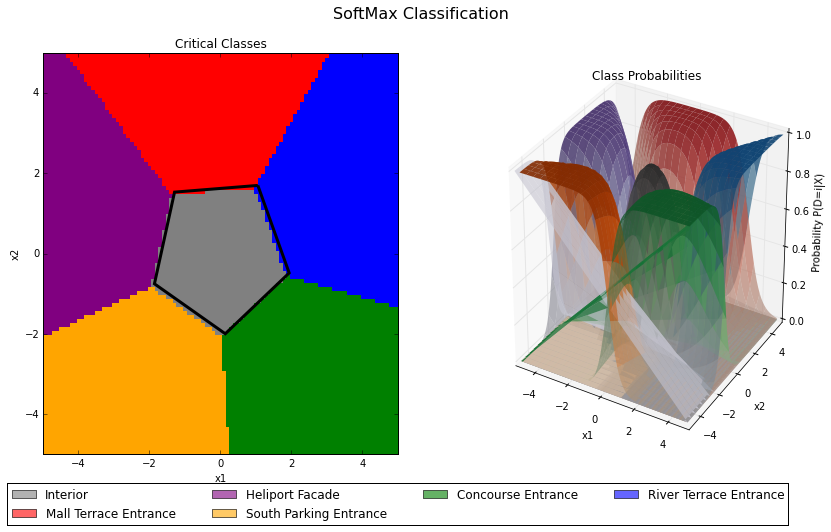

In [2]:
steepness = 5
sm = SoftMax(poly=poly, class_labels=labels, resolution=0.1, steepness=5)
sm.plot(plot_poly=True, plot_normals=False)

As expected, our boundaries stayed the same but our probabilities are less spread out. Looking good! 

However, we need to address a few assumptions. Most importantly, our interior class will not always be centered at the origin. Let's look at a shifted coordinate frame again, with the center of our polygon at $(-2,3)$:

\begin{align}
\mathbf{x}' &= \begin{bmatrix}x & y\end{bmatrix}^T + \begin{bmatrix}2 & -3\end{bmatrix}^T = \begin{bmatrix}x + 2 & y -3\end{bmatrix}^T \\
0 &= (\mathbf{w}_i - \mathbf{w}_j)^T \mathbf{x}' + (b_i - b_j) \\
&= (\mathbf{w}_i - \mathbf{w}_j)^T \mathbf{x} + (\mathbf{w}_i - \mathbf{w}_j)^T \mathbf{b} + (b_i - b_j)\\
&= \mathbf{w}_i^T \mathbf{x} + \mathbf{w}_i^T \mathbf{b} + b_i\\
&= w_{i,x}x + w_{i,y}y + \begin{bmatrix}w_{i,x} & w_{i,y}\end{bmatrix}\begin{bmatrix}-2 \\ 3\end{bmatrix}  + b_i\\
&= w_{i,x}x + w_{i,y}y  + b_i^\prime\\
\end{align}

But, remember that we need to perform the coordinate shift on the points we use as well:

$$
\begin{bmatrix}
x_1 + 2 & y_1 - 3 & 1 \\
x_2 + 2 & y_2 - 3 & 1 \\
x_3 + 2 & y_3 - 3 & 1 \\
\end{bmatrix}
\begin{bmatrix}
w_{i,x}\\
w_{i,y}\\
b_i^\prime
\end{bmatrix}
=\begin{bmatrix}
0\\
0\\
0
\end{bmatrix}
$$


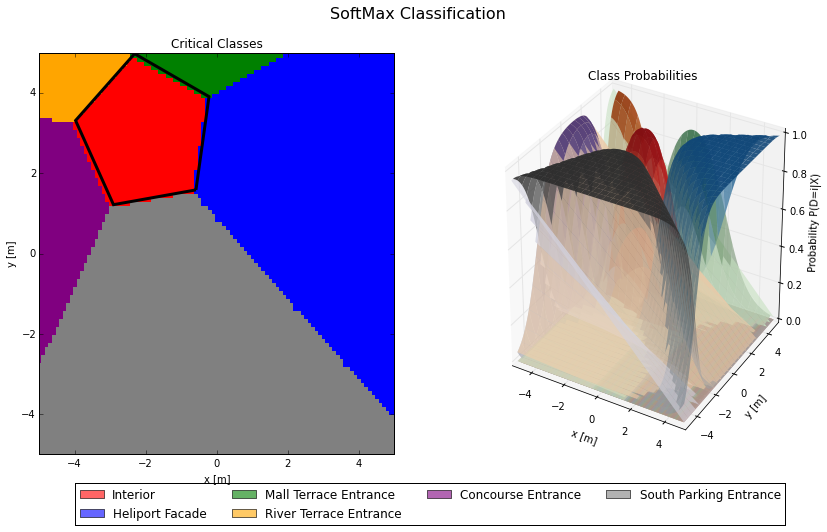

In [3]:
poly = make_regular_2D_poly(5, max_r=2, theta=-np.pi/4, origin=(-2,3))
sm = SoftMax(poly=poly, class_labels=labels, resolution=0.1, steepness=5)
sm.plot(plot_poly=True, plot_normals=False)

Great! We've successfully decomposed the space around the Pentagon, so we can tell the automatic security bots where the suspect is without having to pull out a map of the Pentagon and show them directly where on the map our intruder may be. That is, we've replaced communication of specific coordinates with the communication of 'zones' formed by spatial relationships to landmarks.

However, the methodology build up to this point doesn't work for all cases. For instance: what happens if we want to use a non-convex shape to develop a SoftMax model? [Chapter 4](04_mms.ipynb) will dive into some of these pitfalls and how to get around them. For the time being, we'll simply show that, while we can't handle non-convex shapes yet, we can handle convex irregular shapes:

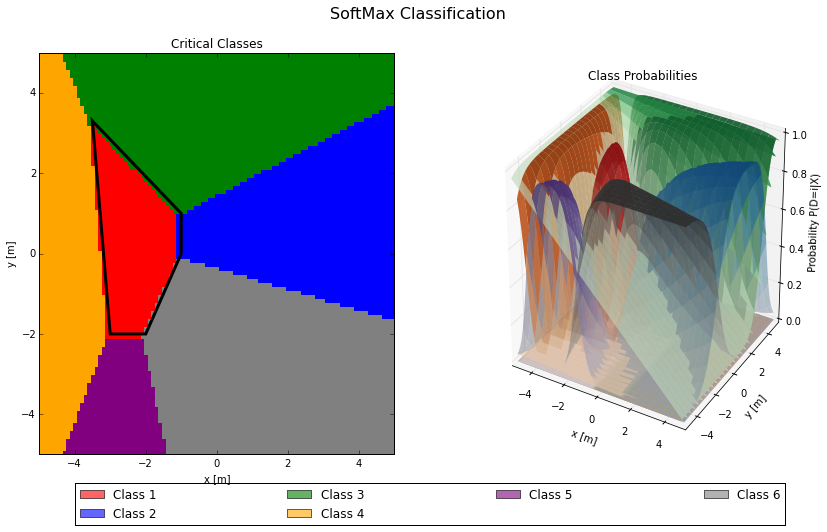

In [7]:
poly = Polygon([(-1.0, 0.0),
                (-1.0, 1.0),
                (-3.5, 3.3),
                (-3.0, -2.0),
                (-2.0, -2.0),
                ])

sm = SoftMax(poly=poly, steepness=6)
sm.plot(plot_poly=True)

In [6]:
from IPython.core.display import HTML

# Borrowed style from Probabilistic Programming and Bayesian Methods for Hackers
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()